In [90]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LogisticRegression as LogReg
import category_encoders as ce
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)

In [91]:
# used to ignore warnings

import warnings; warnings.simplefilter('ignore')

In [95]:
test0 = pd.read_csv('https://raw.githubusercontent.com/SeanAntosiak/DS-Unit-2-Regression-Classification/master/data/tanzania/test_features.csv')
train0 = pd.read_csv('https://raw.githubusercontent.com/SeanAntosiak/DS-Unit-2-Regression-Classification/master/data/tanzania/train_features.csv')
trainLabels = pd.read_csv('https://raw.githubusercontent.com/SeanAntosiak/DS-Unit-2-Regression-Classification/master/data/tanzania/train_labels.csv')
sample = pd.read_csv('https://raw.githubusercontent.com/SeanAntosiak/DS-Unit-2-Regression-Classification/master/data/tanzania/sample_submission.csv')

In [96]:
train0.head(1)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [97]:
# checks if quantity column is a duplicate
# since there are no rows where the two are not equal
# I will drop one of the rows later

train0[train0['quantity']!=train0['quantity_group']][['quantity','quantity_group']].head()

,quantity,quantity_group


In [98]:
# checks if payment column is a duplicate
# it is not but they convey the same information 
# I will drop one of the rows later

train0[train0['payment']!=train0['payment_type']][['payment','payment_type']].head()

,payment,payment_type
0,pay annually,annually
2,pay per bucket,per bucket
5,pay per bucket,per bucket
11,pay when scheme fails,on failure
13,pay monthly,monthly


In [99]:
# checks if quantity colunm is a duplicate
# they look to convey the same information 
# will look further to see if I should drop

train0[train0['scheme_management']!=train0['management']][['scheme_management','management']].head()

,scheme_management,management
0,VWC,vwc
1,Other,wug
2,VWC,vwc
3,VWC,vwc
4,NaN,other


In [100]:
# checking occurances of each value

train0['scheme_management'].value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [101]:
# close to the same values as the other column,
# I will just keep one of these columns

train0['management'].value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [102]:
# looking at how these three columns relate
# it looks as if source and source_type represent the same thing
# but source_class is a more broad classification from 2 catagories
# I will drop the source column later
 
train0[train0['source_type']!=train0['source']][['source','source_type','source_class']].head(10)


,source,source_type,source_class
3,machine dbh,borehole,groundwater
6,machine dbh,borehole,groundwater
8,machine dbh,borehole,groundwater
10,machine dbh,borehole,groundwater
15,machine dbh,borehole,groundwater
16,river,river/lake,surface
17,river,river/lake,surface
22,river,river/lake,surface
23,river,river/lake,surface
26,machine dbh,borehole,groundwater


In [103]:
# checking to see if waterpoint type is a duplicate col
# need to check further

train0[train0['waterpoint_type_group']!=train0['waterpoint_type']][['waterpoint_type_group','waterpoint_type']].head(10)

,waterpoint_type_group,waterpoint_type
2,communal standpipe,communal standpipe multiple
3,communal standpipe,communal standpipe multiple
5,communal standpipe,communal standpipe multiple
53,communal standpipe,communal standpipe multiple
55,communal standpipe,communal standpipe multiple
62,communal standpipe,communal standpipe multiple
75,communal standpipe,communal standpipe multiple
89,communal standpipe,communal standpipe multiple
95,communal standpipe,communal standpipe multiple
96,communal standpipe,communal standpipe multiple


In [104]:
# checking values for waterpoint group

train0['waterpoint_type_group'].value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

In [105]:
# this column apears to have communal standpipe split into two seperate columns
# I will keep this column and drop the other

train0['waterpoint_type'].value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

In [106]:
# looking at how these three columns relate
# its hard to tell but type_class seems to be the most broad 
# and extraction_type the most spesific
# I will look a little more before deciding to drop anything
 
train0[train0['extraction_type']!=train0['extraction_type_group']][['extraction_type','extraction_type_group','extraction_type_class']].head()

,extraction_type,extraction_type_group,extraction_type_class
31,ksb,submersible,submersible
45,windmill,wind-powered,wind-powered
66,other - rope pump,rope pump,rope pump
88,ksb,submersible,submersible
92,ksb,submersible,submersible


In [107]:
# checking how many rows have different values for two of the columns
# it is a pretty big number, but even so most of the values are still 
# matched up pretty consistently (example: ksb is always matched with submersible)
# i will compare this shape to the size of the total Dataframe 

train0[train0['extraction_type']!=train0['extraction_type_group']][['extraction_type','extraction_type_group','extraction_type_class']].shape

(2469, 3)

In [108]:
# the last columns are only a small portion of the total
# I will drop the later two columns for now
# I may add them back if needed later

train0.shape

(59400, 40)

In [109]:
# checking if row is duplicate
# not enough information yet to decide on droping

train0[['water_quality', 'quality_group']].head()

,water_quality,quality_group
0,soft,good
1,soft,good
2,soft,good
3,soft,good
4,soft,good


In [110]:
# checking value counts of water quality column when the columns dont have the same values

train0[train0['water_quality']!=train0['quality_group']][['water_quality','quality_group']]['water_quality'].value_counts()

soft                  50818
coloured                490
salty abandoned         339
fluoride abandoned       17
Name: water_quality, dtype: int64

In [111]:
# looks the same as the last column but changes soft to good.
# I will drop the water_quality column

train0[train0['water_quality']!=train0['quality_group']][['water_quality','quality_group']]['quality_group'].value_counts()

good        50818
colored       490
salty         339
fluoride       17
Name: quality_group, dtype: int64

In [112]:
# only one value, will remove column

train0['recorded_by'].value_counts()

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

In [113]:
# drops columns mentioned previously

train = train0.drop(columns=['recorded_by', 'quantity_group', 'payment', 'management', 'source', 'waterpoint_type_group', 'extraction_type_group', 'extraction_type_class', 'water_quality'])
test = test0.drop(columns=['recorded_by', 'quantity_group', 'payment', 'management', 'source', 'waterpoint_type_group', 'extraction_type_group', 'extraction_type_class', 'water_quality'])

In [114]:
# Looks at remaining features

train.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'scheme_management',
       'scheme_name', 'permit', 'construction_year', 'extraction_type',
       'management_group', 'payment_type', 'quality_group', 'quantity',
       'source_type', 'source_class', 'waterpoint_type'],
      dtype='object')

In [115]:
# check what percentage of pumps work

trainLabels['status_group'].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [116]:
# creates train and test split

Xtrain0, Xval0, ytrain0, yval0 = tts(train, trainLabels['status_group'], train_size=0.85, test_size=0.15, random_state=8)

In [117]:
# creates a baseline model from logistic regression of numeric values

mod0 = LogReg(max_iter=5000, n_jobs=-1)
mod0.fit(Xtrain0.select_dtypes('number'), ytrain0)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=5000, multi_class='warn',
          n_jobs=-1, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [118]:
# checks accuracy of mod0

mod0.score(Xval0.select_dtypes('number'), yval0)

0.5548821548821549

In [119]:
# looks at how many unique features are in each column
# in order to determine which rows to run one hot encoding on

Xtrain0.describe(exclude='number').T

,count,unique,top,freq
date_recorded,50490,353,2011-03-15,491
funder,47411,1741,Government Of Tanzania,7761
installer,47400,1943,DWE,14765
wpt_name,50490,32419,none,3045
basin,50490,9,Lake Victoria,8732
subvillage,50163,17788,Shuleni,443
region,50490,21,Iringa,4532
lga,50490,125,Njombe,2142
ward,50490,2088,Igosi,261
public_meeting,47649,2,True,43347


In [120]:
# does one hot encoded on certain selected features with low cardinality
# also includes some numbered features

catFeats1 = ['public_meeting', 'payment_type', 'permit', 'waterpoint_type', 'source_class']
numFeats1 = list(Xtrain0.drop(columns=['id']).select_dtypes('number').columns)

feats1 = catFeats1+numFeats1

Xtrain1 = Xtrain0[feats1]
Xval1 =Xval0[feats1]

encoder1 = ce.OneHotEncoder(use_cat_names=True)
trainEncoded1 = encoder1.fit_transform(Xtrain1)
valEncoded1 = encoder1.transform(Xval1)

scaler1 = StandardScaler()
XtrainScaled1 = scaler1.fit_transform(trainEncoded1)
XvalScaled1 = scaler1.transform(valEncoded1)

mod1 = LogReg()
mod1.fit(XtrainScaled1, ytrain0)

mod1.score(XvalScaled1, yval0)

0.6586980920314254

In [121]:
# looks at model coeficients

mod1.coef_[0]

array([ 0.02825073, -0.06612463,  0.03738706,  0.        , -0.21712034,
        0.26616516,  0.08941944, -0.15643194,  0.13299212,  0.0077418 ,
        0.00735225,  0.        , -0.00146673,  0.03050536, -0.01334023,
        0.        ,  0.17169545, -0.5094727 ,  0.28692422, -0.24403396,
        0.12305345,  0.01914003,  0.01583184,  0.        , -0.01635035,
        0.00723041,  0.05665343,  0.        ,  0.15140925,  0.25470389,
        0.07857524,  0.09892757, -0.00461625, -0.12058126,  0.07572886,
        0.05175019, -0.16449744])

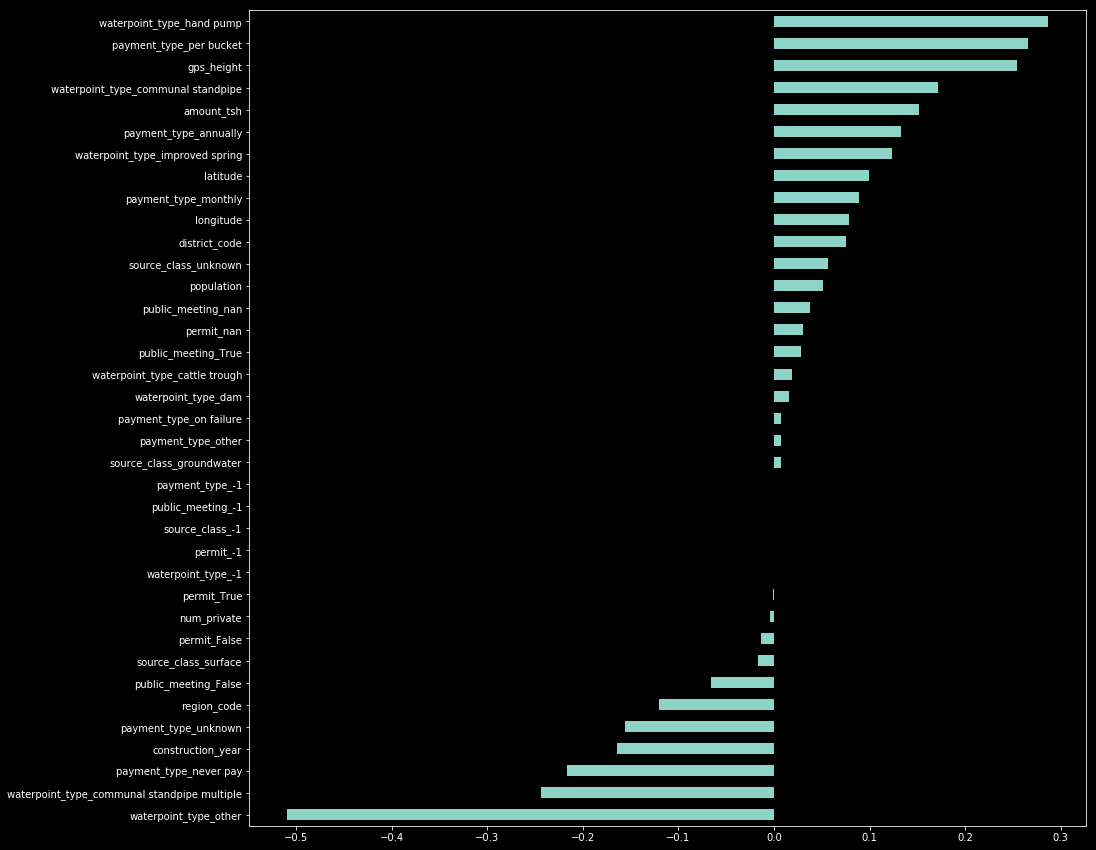

In [122]:
coefs1 = pd.Series(mod1.coef_[0], trainEncoded1.columns)

plt.figure(figsize=(15,15))
plt.style.use('dark_background')
coefs1.sort_values().plot.barh()
plt.show()

In [123]:
# predicts test values using mod1

test1 = test0[feats1]
testEncoded1 = encoder1.transform(test1)
testScaled1 = scaler1.transform(testEncoded1)
pred1 = mod1.predict(testScaled1)

assert all(testEncoded1.columns == trainEncoded1.columns)

In [126]:
# creating a submission dataframe

submission1 = sample.copy()
submission1['status_group'] = pred1

In [131]:
# making sure id order is the same

submission1.head()

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,non functional
3,45559,non functional
4,49871,functional


In [137]:
# id order is the same

test0['id'].head()

0    50785
1    51630
2    17168
3    45559
4    49871
Name: id, dtype: int64

In [151]:
submission1.to_csv('submission1.csv', index=False)